# Lesson 4.6 逻辑回归的手动实现

讨论完梯度下降的相关内容之后，接下来我们尝试使用梯度下降算法求解逻辑回归损失函数，并且通过一系列实验来观察逻辑回归的模型性能。

In [2]:
# 科学计算模块
import numpy as np
import pandas as pd

# 画图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# 自定义模块
from ML_basic_function import *

## 一、逻辑回归损失函数的梯度计算表达式

对于任何模型的手动实现，首先我们都需要考虑关于其损失函数的梯度计算表达式。并且为了方便代码实现，我们需要尽可能的使用矩阵形式进行表示。在线性回归中，我们通过矩阵求导运算，可以非常快速的求解出用矩阵形式表示的损失函数梯度表达式，而在逻辑回归中，由于损失函数表达式的不同，这个过程会略微复杂一些。

在Lesson4.2中，我们从极大似然估计和KL离散两个角度推导了逻辑回归损失函数，对于二分类为逻辑回归模型来说，假设数据集是行列的一个数据集，则二分类交叉嫡损失函数如下：

$$
\operatorname{binary} \operatorname{CE}(\hat{w})=-\frac{1}{m} \sum_{i=1}^m\left[y^{(i)} \cdot \log \left(p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right)+\left(1-y^{(i)}\right) \cdot \log \left(1-p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right)\right]
$$

其中n为样本数量，$\hat{\boldsymbol{x}}^{(i)}$为第条样本(添加了最后全是1的列)，$\hat{w}$为带截距项的线性方程系数向量，$p_{1}$为某条样本在当前参数下逻辑回归输出结果，即预测该样本为1的概率，$y^{0}$为第i条样本的真实类别。对于上述BCE损失函数，梯度表达式为：

$$
\nabla_{\hat{w}} B C E(\hat{w})=\frac{\partial B C E(\hat{w})}{\partial \hat{w}}
$$

其中，$\hat{w}=\left[w_1, w_2, w_3, \ldots, w_n, b\right]$，因此上式可进一步展开：

$$
\nabla_{\hat{w}} B C E(\hat{w})=\frac{\partial B C E(\hat{w})}{\partial \hat{w}}=\left[\frac{\partial B C E(\hat{w})}{\partial w_1}, \frac{\partial B C E(\hat{w})}{\partial w_2}, \ldots, \frac{\partial B C E(\hat{w})}{\partial w_n}, \frac{\partial B C E(\hat{w})}{\partial b}\right]^T
$$

而$\log \left(p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right)=\log \left(\operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)\right)$ ，我们对带入某条数据后的某个参数进行求导，例如对$w_{i}$进行求导，则可得：

$$
\log \left(p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right)^{\prime}=\log \left(\operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)\right)^{\prime}=\frac{1}{\operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)} \cdot \text { Sigmoid }^{\prime}\left(\hat{x}^{(i)} \cdot \hat{w}\right)
$$

对于Sigmoid函数来说，有：

$$
\operatorname{Sigmoid}^{\prime}(x)=\operatorname{Sigmoid}(x)(1-Sigmoid (x))
$$

则上式可进一步得到：

$$
\log \left(p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right)^{\prime}=\left(1-\operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)\right) \cdot\left(\hat{x}^{(i)} \cdot \hat{w}\right)^{\prime}
$$

其中$\hat{x}^{(i)} \cdot \hat{w}=w_1 x_1^{(i)}+w_2 x_2^{(i)}+\ldots+w_n x_n^{(i)}+b$， 对$w_{i}$求导可得：

$$
\left(\hat{x}^{(i)} \cdot \hat{w}\right)^{\prime}=x_i^{(i)}
$$

当然，对截距求导可得：

$$
\left(\hat{x}^{(i)} \cdot \hat{w}\right)^{\prime}=1
$$

$
\text { 因此，在 } \log \left(p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right) \text { 中对 } w_i \text { 求导可得: }
$

$$
\log \left(p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right)^{\prime}=\left(1-\operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)\right) \cdot x_i^{(i)}
$$

而在 $\log \left(p_1\left(\hat{x}_i ; \hat{w}\right)\right)$ 中对 $b$ 求导可得：

$$
\log \left(p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right)^{\prime}=\left(1-\operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)\right) \cdot 1
$$

类似的，在 $\left(1-y^{(i)}\right) \cdot \log \left(1-p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right)$ 中对 $w_i$ 求导可得:

$$
\begin{aligned}
\left(1-y^{(i)}\right) \cdot \log ^{\prime}\left(1-p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right) & =\left(1-y^{(i)}\right) \cdot \log ^{\prime}\left(1-\operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)\right) \\
& =\left(1-y^{(i)}\right) \cdot \frac{1}{\left(1-\operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)\right)} \cdot\left(-\operatorname{Sigmoid}^{\prime}\left(\hat{x}^{(i)} \cdot \hat{w}\right)\right)
\end{aligned}
$$

同样，由于 $\operatorname{Sigmoid}^{\prime}(x)=\operatorname{Sigmoid}(x)(1-\operatorname{Sigmoid}(x))$ ，所以上式可得:

$$
\begin{aligned}
\left(1-y^{(i)}\right) \cdot \log ^{\prime}\left(1-p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right) & =\left(1-y^{(i)}\right) \cdot\left(-\operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)\right) \cdot\left(\hat{x}^{(i)} \cdot \hat{w}\right)^{\prime} \\
& =\left(1-y^{(i)}\right) \cdot\left(-\operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)\right) \cdot x_i^{(i)}
\end{aligned}
$$

类似的，当对截距项求导时

$$
\left(1-y^{(i)}\right) \cdot \log ^{\prime}\left(1-p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right)=\left(1-y^{(i)}\right) \cdot\left(-\operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)\right) \cdot 1
$$

将上述结果带入 $\frac{\partial B C E(\hat{\omega})}{\partial \omega_i}$ ，当对 $\omega_i$ 进行求导时:

$$
\begin{aligned}
\frac{\partial B C E(\hat{w})}{\partial w_i} & =\left(-\frac{1}{m} \sum_{i=1}^m\left[y^{(i)} \cdot \log \left(p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right)+\left(1-y^{(i)}\right) \cdot \log \left(1-p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right)\right]\right]^{\prime} \\
& =-\frac{1}{m} \sum_{i=1}^m\left[y^{(i)} \cdot \log ^{\prime}\left(p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right)+\left(1-y^{(i)}\right) \cdot \log ^{\prime}\left(1-p_1\left(\hat{x}^{(i)} ; \hat{w}\right)\right)\right] \\
& \left.=-\frac{1}{m} \sum_{i=1}^m\left[y^{(i)} \cdot\left(1-\operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)\right) \cdot x_i^{(i)}+\left(1-y^{(i)}\right) \cdot\left(-\operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)\right) \cdot x_i^{(i)}\right)\right] \\
& =-\frac{1}{m} \sum_{i=1}^m\left[x_i^{(i)} y^{(i)}-x_i^{(i)} y^{(i)} \operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)-x_i^{(i)} \operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)+x_i^{(i)} y^{(i)} \operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)\right] \\
& =\frac{1}{m} \sum_{i=1}^m\left(x_i^{(i)}\left(\operatorname{Sigmoid}\left(\hat{x}^{(i)} \cdot \hat{w}\right)-y^{(i)}\right)\right) \\
& =\frac{1}{m} \sum_{i=1}^m\left(x_i^{(i)}\left(\hat{y}^{(i)}-y^{(i)}\right)\right)
\end{aligned}
$$

对截距项b进行求号时：

$$
\left.\frac{\partial B C E(\hat{w})}{\partial w_i}=\frac{1}{m} \sum_{i=1}^m 1 \cdot\left(\hat{y}^{(i)}-y^{(i)}\right)\right)
$$

> 其实，根据定义， $x^{(i)}=\left[x_1^{(i)}, x_2^{(i)}, \ldots, x_n^{(i)}, 1\right] ， x_{n+1}^{(i)}=1 ， 1$ 就是 $x^{(i)}$ 的第 $n+1$ 个分量

因此，逻辑回归损失函数的梯度计算公式为：

$$
\nabla_{\hat{w}} B C E(\hat{w})=\frac{1}{m} \hat{X}^T(\operatorname{Sigmoid}(\hat{X} \cdot \hat{w})-y)
$$

并且，据此我们可以定义逻辑回归的梯度计算公式：

In [3]:
def logit_gd(X, w, y):
    """逻辑回归梯度计算公式
    :param X: 输入数据
    :param w: 权重
    :param y: 标签"""
    m = X.shape[0]
    grad = np.dot(X.T, sigmoid(np.dot(X, w)) - y) / m
    return grad

> 其实，无论是理论推导还是手动实现，对于机器学习的建模流程来说，只要我们采用梯度下降方法进行参数求解，就需要有以下环节：根据算法原理构建损失函数——根据损失函数构建梯度更新表达式——根据梯度表达式进行参数更新，而在这个过程中，损失函数的构建和梯度表达式的计算其实都是涉及理论部分内容相对较深而实践过程高度重复的，即一旦我们推导出逻辑回归模型的梯度计算公式，在未来长期明建模过程中该式都无须更改甚至无须关注，而这部分功能代码，往往都是封装在更高级框架里面的函数或者类。这也是导致我们在调库实现机器学习建模时往往会忽视损失函数和梯度更新表达式的函数形式，而只看重最终建模结果。

当然，这么做其实无可厚非，对于初中级用户来说，首先最重要的是完成建模整个流程，然后在此基础之上不断精进建模技巧。但无论何时，我们都需要知道工具和框架都只是实现的一种途径，其背后的原理才是能够解决问题的关键。

## 二、创建分类数据集生成器

### 1.手动创建分类数据

为了方便展开逻辑回归和后续分类模型的性能探时，我们考虑通过创建可自定义分类难度的分类数据生成器来辅助后续实验的开展。在此前的回归数据生成器定义的过程中，我们曾介绍，对于回归数据集来说，越是服从高阶多项式回归规律、或者干扰项越大，建模难度就越高，而对于分类问题来说，有一种非常简单的方式去划分数据集的分类难度，那就是：在样本空间（特征空间）中观察不同类别的样本分布，各类别样本点重合度越高、边界约不明显，则分类难度越高。例如我们通过创健各列都服从高斯分布的分类数据集如下：

In [4]:
# 创建初始标记值
num_inputs = 2  # 特征数
num_examples = 500  # 样本数

In [5]:
np.random.seed(24)
data0 = np.random.normal(4, 2, size=(num_examples, num_inputs))
data1 = np.random.normal(-2, 2, size=(num_examples, num_inputs))

In [6]:
data0[:10]

array([[6.65842435, 2.4599331 ],
       [3.36743928, 2.01837923],
       [1.85836749, 1.12257344],
       [5.1288337 , 4.59144378],
       [0.74719153, 4.4391304 ],
       [5.3576096 , 7.77854546],
       [5.9230768 , 4.20802239],
       [3.03766937, 5.70045706],
       [6.90684933, 6.11547487],
       [4.33112321, 5.03003676]])

值得注意的是，对于random.normale函数来说，参数size决定接下来数组的基本形状，而在创健任意维度数组时，在均值参数和标准差参数都是标量的情况下，实际上均值和方差约束的是所有数据

In [7]:
data0.mean()

4.027189146259833

In [8]:
data0.std()

2.026404030444323

当然，对于其中的海一列数据来说，其实都是从整体数据中抽样而来，因此各列也都服从均值为4、标准差为2的正态分布

In [9]:
data0.mean(axis=0)

array([3.90407794, 4.15030035])

In [10]:
data0.std(axis=0)

array([2.05961619, 1.98501764])

同时，我们令data0的标签为label0,data1标签为label1

In [11]:
labels0 = np.zeros(500)
labels1 = np.ones(500)

> 一般来说，用于表示分类数据集类别的数字可以自行定义，对于二分类问题，一般会用0/门来表示两个类别，更进一步的，我们往往会令有待重点识别的类为1，其他类别为0。

数据对应的标签分别合并为featuresi和labels,即数据集的整体特征矩阵和标签数组

In [12]:
features = np.concatenate((data0, data1), axis=0)
labels = np.concatenate((labels0, labels1), axis=0)

由于数据集只包含两个特征，因此我们可以通过绘制样本空间的样本点的分布来进行观察，其中每个点代表每一条样本，而每个点的不同着色则代表不同类别。

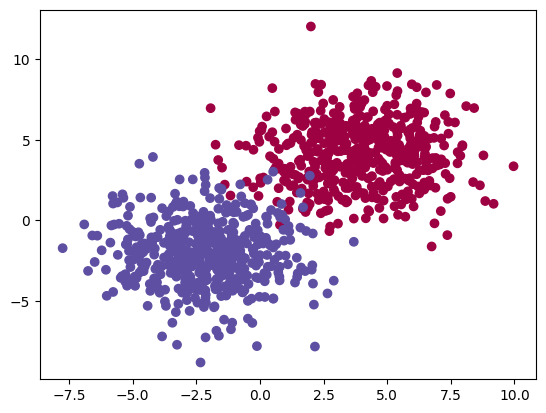

In [13]:
plt.scatter(features[:, 0], features[:, 1], c=labels, cmap=plt.cm.Spectral)

而对于上述两个类别来说，很明显，第一类(data0,列均值为4)位于样本空间的右上角，而第二类(data0,列均值为-2)则位于样本空间的左下角。并且，我们可以从另一个角度来理解两类数据的分布，首先，均值实际上也就代表着样本分布的中心，因此第一类数据的中心点为(4,4)，而第二类的数据的中心点为(-2，-2)，此外，方差（及标准差）其实表示数据的离散程度，方差越大、数据距离中心点的离散程度就越大。

C:\Users\16179\AppData\Local\Temp\ipykernel_1868\4253051393.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(a1[:, 0], a1[:, 1], c='r', cmap=plt.cm.Spectral)
C:\Users\16179\AppData\Local\Temp\ipykernel_1868\4253051393.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(a2[:, 0], a2[:, 1], c='b', cmap=plt.cm.Spectral)


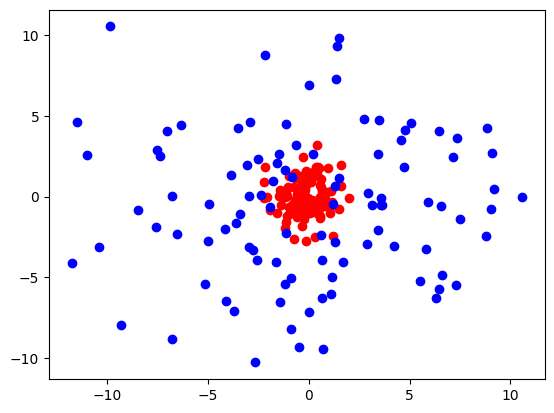

In [14]:
a1 = np.random.normal(0, 1, size=(100, 2))
a2 = np.random.normal(0, 5, size=(100, 2))
plt.scatter(a1[:, 0], a1[:, 1], c='r', cmap=plt.cm.Spectral)
plt.scatter(a2[:, 0], a2[:, 1], c='b', cmap=plt.cm.Spectral)

因此，对于上述创建数据集过程而言，如果我们缩短中心点之间的距离、增加每一个点簇的方差，则能够进一步加深两个点簇彼此交错的情况

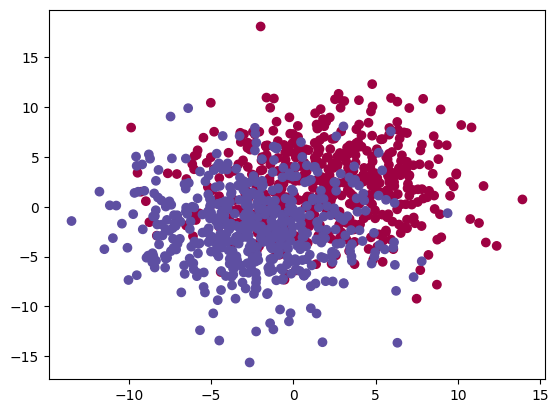

In [15]:
np.random.seed(24)
data0 = np.random.normal(2, 4, size=(num_examples, num_inputs))
data1 = np.random.normal(-2, 4, size=(num_examples, num_inputs))

features = np.concatenate((data0, data1), axis=0)
labels = np.concatenate((labels0, labels1), axis=0)

plt.scatter(features[:, 0], features[:, 1], c=labels, cmap=plt.cm.Spectral)

能够看出，此时两个点簇（两类数据）在样本空间中的边界非常模糊。反之，如果提高中心点间距、减少每个点簇方差，则会减少各点簇彼此交错的情况，并且能够呈现出一条更加清晰的边界。

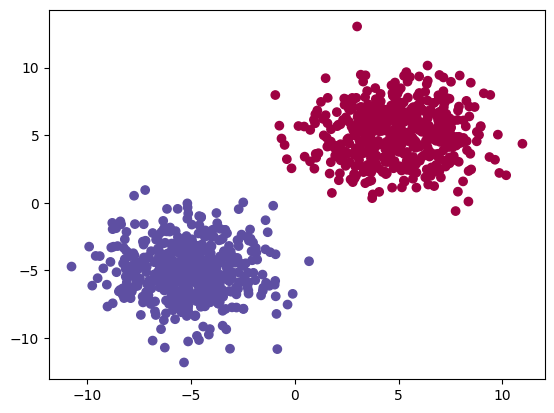

In [16]:
np.random.seed(24)
data0 = np.random.normal(5, 2, size=(num_examples, num_inputs))
data1 = np.random.normal(-5, 2, size=(num_examples, num_inputs))

features = np.concatenate((data0, data1), axis=0)
labels = np.concatenate((labels0, labels1), axis=0)
plt.scatter(features[:, 0], features[:, 1], c=labels, cmap=plt.cm.Spectral)


对于上述分布的分类数据集来说，我们甚至能够清楚的在样本空间中找出一条线性边界对两类数据进行切分。而对于分类数据来说，边界越清晰，彼此交错的情况越少、则分类越简单。

### 2.创建分类数据生成器

在有了上述基础只是铺垫之后，接下来我们考虑创建分类数据生成器函数，并目拥有以下两点额外功能：能够创建多分类数据集，并且可以通过参数手动调整数据分类难度。

In [17]:
def arrayGenClass(num_examples=500, num_inputs=2, num_class=3, deg_dispersion=[4, 2], bias= False):
    """生成多分类数据
    :param num_examples: 样本数
    :param num_inputs: 特征数
    :param num_class: 分类数
    :param deg_dispersion: 分散程度
    :param bias: 是否有偏置
    :return: 特征和标签"""
    cluster_1 = np.empty([num_examples, 1])     # 每一类标签数组的形状
    mean_ = deg_dispersion[0]               # 每一类特诊数组的均值的参考值
    std_ = deg_dispersion[1]                # 每一类特征数组的标准差的参考值
    lf = []                                # 特征数组的列表
    ll = []                                # 标签数组的列表
    k = mean_ * (num_class - 1) / 2        # 每一类特征均值的惩罚因子

    for i in range(num_class):
        data_tep = np.random.normal(mean_ * i - k, std_, size=(num_examples, num_inputs))   # 生成每一类的特征数组
        lf.append(data_tep)                                                                # 将每一类的特征数组加入列表
        labels_tep = np.full_like(cluster_1, i)                                     # 生成每一类的标签数组
        ll.append(labels_tep)                                                              # 将每一类的标签数组加入列表
    
    features = np.concatenate(lf, axis=0)                                                  # 将特征数组列表合并成特征数组
    labels = np.concatenate(ll, axis=0)                                                    # 将标签数组列表合并成标签数组
    if bias:
        features = np.concatenate((features, np.ones((features.shape[0], 1))), axis=1)
    return features, labels

其中，需要注意的是关于离散程度参数的理解和使用。参数deg dispersion是一个包含两个元素的list,其中第二个元素为每一类数据的方差，而第一个元素则是每一类数据的均值的一个参考值(mean)，而最终每一类数据的均值则由mean、总类别数num_class和当前类别标签三者共同决定。这里如此进行设计的一个重要原因是，我们希望无论最终创健几个类别的数据，最终各类中心点的均值基本是围绕原点分布的。即假设总共创建两个类别的数据，并且假设mean取值为2，为每一类的编号(0,1)，则相比采用i*mean创建中心点分别为（0, 0）、(2, 2)的两个簇，我们更希望创健中心点为(-1，-1)、(1, 1)为中心点的两个簇。

为了满足该要求，我们需要在原始i*mean的基础上进行修改。这里我们创建了一个惩罚因子k=mean*(numc1ass-1)/2,用于修正i*mean.,在进行每个簇中心点计算时，计算公式为i*mean_-k,当总类别为2、mean_=2时，每个中心点计算公式为i2-1,为0时，第一类中心点计算结果为(-1，-1)，当为1时，第二类中心点计算结果为(1,1)，能够满足上述中心点围绕原点分布的基本要求。

接下来，测试上述函数性能

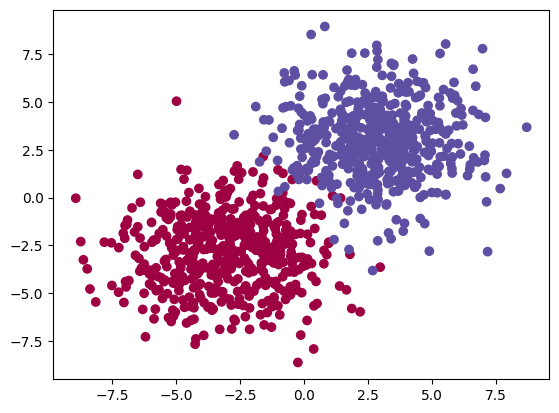

In [18]:
# 设置随机种子
np.random.seed(24)

# 生成数据
f, l  = arrayGenClass(num_class= 2, deg_dispersion= [6, 2], bias= True)

# 画图
plt.scatter(f[:, 0], f[:, 1], c=l, cmap=plt.cm.Spectral)

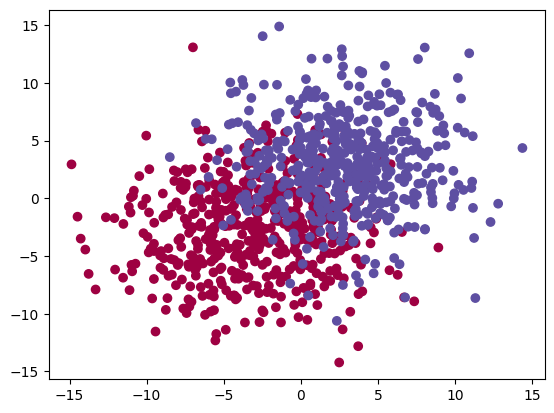

In [19]:
# 设置随机种子
np.random.seed(24)

# 生成数据
f1, l1 = arrayGenClass(num_class= 2, deg_dispersion= [6, 4], bias= True)

# 画图
plt.scatter(f1[:, 0], f1[:, 1], c=l, cmap=plt.cm.Spectral)

## 三、逻辑回归的手动实现

接下来，尝试进行逻辑回归的手动实现。其基本建模流程依然遵照机器学习的一般流程，可以通过如下方式来执行。

* 数据准备

此处直接利用上述数据和进行模型模型训练，在无其他特殊要求情况下，我们对数据集进行训练集和测试集的切分，并进行数据归一化处理。

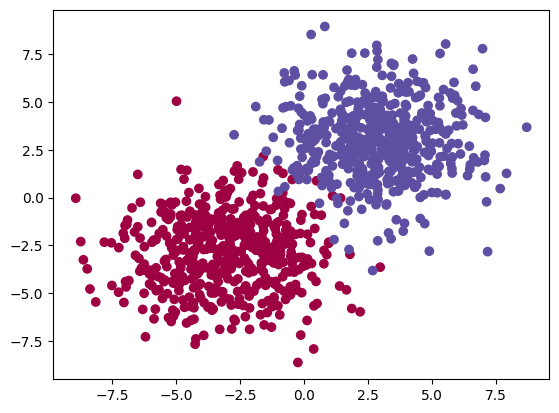

In [20]:
# 设置随机数种子
np.random.seed(24)

# 生成数据
f, l = arrayGenClass(num_class= 2, deg_dispersion= [6, 2], bias= True)

# 画图
plt.scatter(f[:, 0], f[:, 1], c=l, cmap=plt.cm.Spectral)

In [21]:
# 数据切分
X_train, X_test, y_train, y_test = array_split(f, l)

In [22]:
X_train

array([[-1.8548796 , -2.70483481,  1.        ],
       [-1.87637683, -2.41926232,  1.        ],
       [ 1.94989069,  4.23222036,  1.        ],
       ...,
       [ 2.87532044,  0.3972172 ,  1.        ],
       [ 3.40818137,  3.98428395,  1.        ],
       [-0.25339125, -8.61214233,  1.        ]])

In [23]:
X_test

array([[ 3.89897105,  4.36406577,  1.        ],
       [-1.34183767, -5.4001881 ,  1.        ],
       [ 2.51468003,  2.5656945 ,  1.        ],
       [ 6.44964778,  2.68891653,  1.        ],
       [ 2.09992517,  1.45376719,  1.        ],
       [ 3.29152071, -1.84196332,  1.        ],
       [-0.30325369, -4.82751704,  1.        ],
       [ 3.6890838 ,  3.12407552,  1.        ],
       [ 2.18449546,  2.28340341,  1.        ],
       [ 2.26674673,  1.52043045,  1.        ],
       [ 3.30039994,  1.3702528 ,  1.        ],
       [ 3.43130776,  2.58399697,  1.        ],
       [-3.93241743, -7.19424325,  1.        ],
       [-5.31023153, -6.27617573,  1.        ],
       [-0.21429035, -3.12665597,  1.        ],
       [-4.15921652, -1.25778777,  1.        ],
       [-2.78242208, -2.92646614,  1.        ],
       [-3.13612795, -2.57394161,  1.        ],
       [-2.87904048, -1.10809458,  1.        ],
       [ 1.40352329,  2.81068096,  1.        ],
       [-3.56173979, -4.73877731,  1.   

数据归一化过程

In [24]:
mean = X_train[:, :-1].mean(axis=0)
std = X_train[:, :-1].std(axis=0)

X_train[:, :-1] = (X_train[:, :-1] - mean) / std
X_test[:, :-1] = (X_test[:, :-1] - mean) / std

In [25]:
X_train

array([[-0.54046519, -0.81824522,  1.        ],
       [-0.54654998, -0.73750376,  1.        ],
       [ 0.53647537,  1.14310619,  1.        ],
       ...,
       [ 0.79841834,  0.05881485,  1.        ],
       [ 0.94924468,  1.07300578,  1.        ],
       [-0.08716377, -2.48845047,  1.        ]])

In [26]:
X_test[:10]

array([[ 1.08816274,  1.18038356,  1.        ],
       [-0.39524863, -1.58031715,  1.        ],
       [ 0.69633905,  0.67192025,  1.        ],
       [ 1.81013201,  0.70675949,  1.        ],
       [ 0.57894265,  0.35753899,  1.        ],
       [ 0.91622387, -0.57428086,  1.        ],
       [-0.10127734, -1.41840274,  1.        ],
       [ 1.02875413,  0.82979436,  1.        ],
       [ 0.60288027,  0.59210656,  1.        ],
       [ 0.6261615 ,  0.37638705,  1.        ]])

* 初始化参数与核心参数设置

接下来定义参数初始化及核心参数

In [27]:
# 设置随机数种子
np.random.seed(24)

# 参数初始值
n = f.shape[1]
w = np.random.randn(n, 1)

#核心参数
batch_size = 50
num_epoch = 200
lr_init = 0.2

并且，由于需要执行学习率调度，因此需要定义匿名函数

In [28]:
lr_lambda = lambda epoch: 0.95 ** (epoch)

In [29]:
w.shape

(3, 1)

In [30]:
w

array([[ 1.32921217],
       [-0.77003345],
       [-0.31628036]])

* 模型训练

然后，带入训练数据进行模型训练

In [31]:
for i in range(num_epoch):
    w = sgd_cal(X_train, w, y_train, logit_gd, lr=lr_init*lr_lambda(i), batch_size=batch_size, epoch=1)
    

In [32]:
w

array([[3.1894049 ],
       [2.30553244],
       [0.1691708 ]])

* 模型结果测试

模型训练完成后，测试模型效果，首先，对于逻辑回归来说，在给出线性方程参数后，模型输出的概率结果为：

In [33]:
yhat = sigmoid(X_train.dot(w))
yhat[:10]

array([[0.03103592],
       [0.03646214],
       [0.9891821 ],
       [0.08059581],
       [0.0043602 ],
       [0.05225521],
       [0.96094581],
       [0.00100699],
       [0.60388201],
       [0.99752817]])

然后我们利用logit_cla函数将其转化为分类结果

In [34]:
logit_cla(yhat, thr=0.5)[:10]

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.]])

至此我们即得出了模型在训练数据集上的预测结果。当然，我们还可以利用其与训练集的真是标签进行比较，来计算模型在训练集上的预测准确率。

In [35]:
(logit_cla(yhat, thr=0.5) == y_train).mean()

0.9871428571428571

注意，此处我们借助了隐式转化，将布尔型对象转化为浮点型对像。当然，我们也可以将上述准确率计算过程封装为一个函数。

In [36]:
def logit_acc(x,  w, y, thr=0.5):
    """逻辑回归准确率计算公式
    :param x: 输入数据
    :param w: 权重
    :param y: 标签
    :param thr: 阈值
    :return: 准确率"""
    yhat = sigmoid(x.dot(w))
    yhat = logit_cla(yhat, thr)
    acc = (yhat == y).mean()
    return acc

In [37]:
# 训练集准确率
logit_acc(X_train, w, y_train, thr=0.5)

0.9871428571428571

In [38]:
# 测试集准确率
logit_acc(X_test, w, y_test, thr=0.5)

0.98

至此，我们即完成了整个逻辑回归手动建模过程。

* 模型准确率变化函数

更进一步的，我们可以借助Lesson4.5中观察损失函数伴随迭代不断变化的过程中的代码思路，来观察伴随迭代过程模型准确率逐渐提升的过程。

In [39]:
# 设置随机数种子
np.random.seed(24)

# 参数初始值
n = f.shape[1]
w = np.random.randn(n, 1)

# 记录迭代过程中准确率计算结果
train_acc = []
test_acc = []

In [40]:
w

array([[ 1.32921217],
       [-0.77003345],
       [-0.31628036]])

In [41]:
for i in range(num_epoch):
    w = sgd_cal(X_train, w, y_train, logit_gd, lr=lr_init*lr_lambda(i), batch_size=batch_size, epoch=1)
    train_acc.append(logit_acc(X_train, w, y_train, thr=0.5))
    test_acc.append(logit_acc(X_test, w, y_test, thr=0.5))

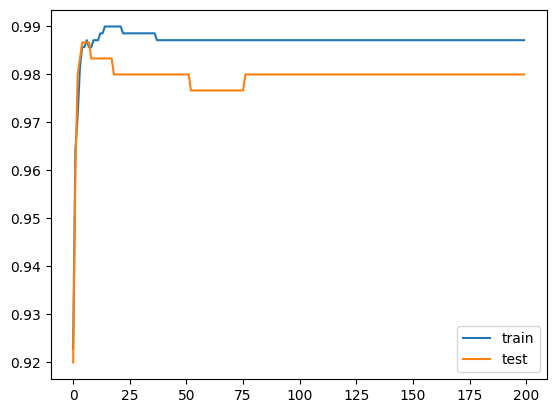

In [42]:
# 观察准确率变化
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()

能够发现，由于数据集本身性质较好，即数据集中各类别边界较为明显，因此整体迭代收敛速度较快，并且模型最终准确率较高。

## 四、逻辑回归的分类性能瓶颈与算法评价

尽管上述建模结果较好，但是像上述数据集一般、不同类别数据边界如此明显的数据集却并不常见。一种更加常见的情况是不同类别的数据集彼此之间存在一定的交叉、数据集之间的边界并不明显。因此，我们尝试带入更加复东的数据集，即带入f1、l1带入进行建模，来测试逻辑回归模型性能。

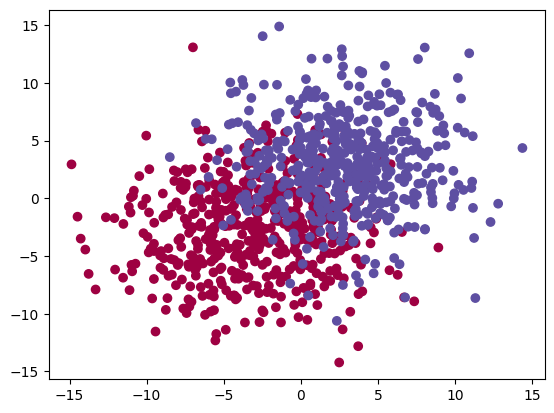

In [43]:
# 数据分布
plt.scatter(f1[:, 0], f1[:, 1], c=l1, cmap=plt.cm.Spectral)

In [44]:
# 设置随机数种子
np.random.seed(24)

# 数据切分与归一化
X_train, X_test, y_train, y_test = array_split(f1, l1)
mean = X_train[:, :-1].mean(axis=0)
std = X_train[:, :-1].std(axis=0)
X_train[:, :-1] = (X_train[:, :-1] - mean) / std
X_test[:, :-1] = (X_test[:, :-1] - mean) / std


In [45]:
X_train

array([[-0.13869677, -0.53505829,  1.        ],
       [-0.14755539, -0.41940515,  1.        ],
       [ 0.19293434,  1.05939775,  1.        ],
       ...,
       [ 0.574287  , -0.49372856,  1.        ],
       [ 0.79386924,  0.95898674,  1.        ],
       [ 0.52124727, -2.92744086,  1.        ]])

In [46]:
# 设置随机数种子
np.random.seed(24)

# 核心参数
batch_size = 50
num_epoch = 200
lr_init = 0.2

# 参数初始值
n = f1.shape[1]
w = np.random.randn(n, 1)

# 记录迭代过程中准确率计算结果
train_acc = []
test_acc = []

In [47]:
w

array([[ 1.32921217],
       [-0.77003345],
       [-0.31628036]])

In [48]:
for i in range(num_epoch):
    w = sgd_cal(X_train, w, y_train, logit_gd, lr=lr_init*lr_lambda(i), batch_size=batch_size, epoch=1)
    train_acc.append(logit_acc(X_train, w, y_train, thr=0.5))
    test_acc.append(logit_acc(X_test, w, y_test, thr=0.5))

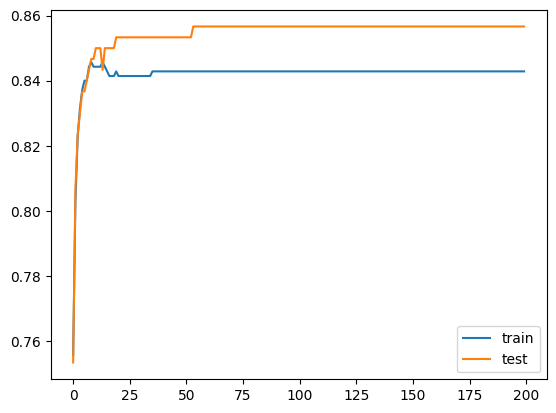

In [49]:
# 观察准确率变化
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()

能的够看出，横型准确率大幅下降。当然，随着数据集中不同簇彼此交错情况越多、边界越模湖，最终横型准确率还将进一步下降。当然，我们在下一小节中，还将通过绘制决策边界的方法来探时逻辑回归的算法性能，我们将发现对于逻辑回归模型来说，对于二维样本空间的数据来说，只能构建线性决策边界来对数据类别进行划分，因此如果我们单独只看模型对于复杂数据的分类判别能力，那么在所有分类模型中，逻组回归其实并不属于性能最强的第一梯队。

但是，逻辑回归仍然凭借其线性方程的模理型结构，拥有非常好的可解释性，使得其在金融风控领域应用广泛（如评分卡模型），同时我们他可以借助逻辑回归进行特征选择，并且与其他算法进行集成等。跟多关于逻辑回归的横型应用，我们将在下一个阶段重点展开讨论。